# Programming Exercise: Logistic Regression



## Introduction

In this exercise, you will implement logistic regression and apply it to two different datasets.

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook.

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, and [`matplotlib`](https://matplotlib.org/) for plotting.

### Section 1 Logistic Regression

In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university. Suppose that you are the administrator of a university department and
you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions
decision. Your task is to build a classification model that estimates an applicant’s probability of admission based the scores from those two exams.

The following cell will load the data and corresponding labels:

In [348]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [349]:

students = pd.read_csv("ex2data1.txt", names=["First_Exam", "Second_Exam", "Admission_Status"])
# type casting from pandas series and pandas dataframe to numpy array
X = np.array(students[["First_Exam", "Second_Exam"]])
y = np.array(students["Admission_Status"])
# size of dataset
number_of_samples = y.size
# size of X matrix, m= rows, n= features
m,n = X.shape
print('size of samples: {}'.format(number_of_samples))

size of samples: 100


In [350]:
students.head()

,First_Exam,Second_Exam,Admission_Status
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


### 1.1 Visualizing the data

Before starting to implement any learning algorithm, it is always good to visualize the data if possible.
please visualize the first dataset using the package `matplotlib`.

In [351]:
import matplotlib.pyplot as plt

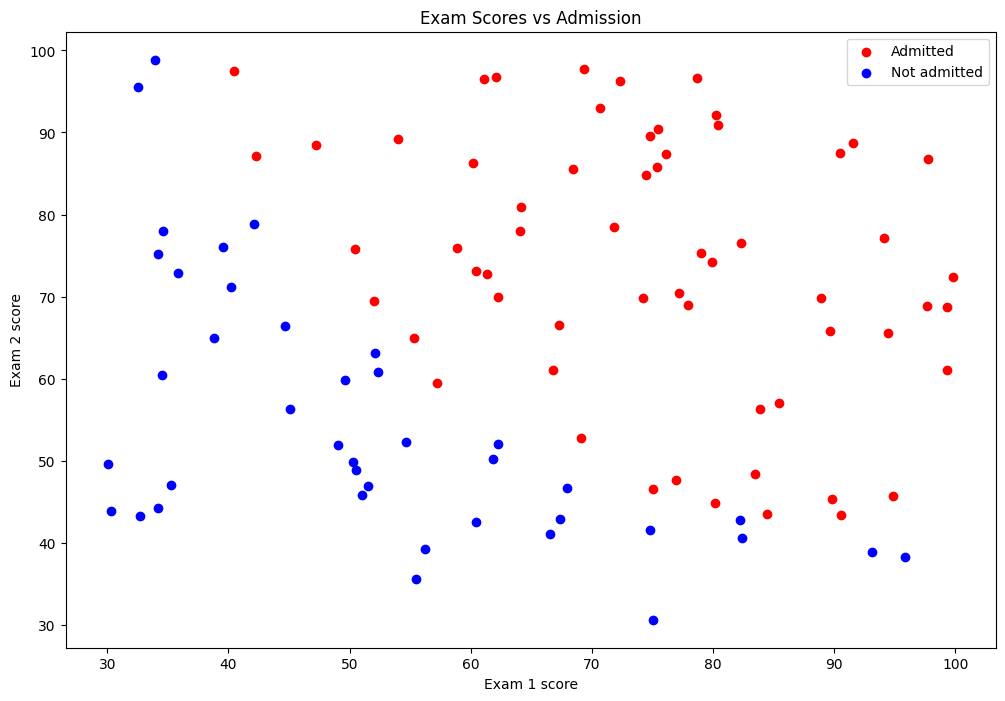

In [352]:

def plot_data(X, y):
    """
    Plots the data points X and y into a new figure.
    
    Parameters
    ----------
    X : array_like
        Data points to be plotted. Each row is a single example.
    
    y : array_like
        Labels for the data points. A vector of shape (m, ).
    
    Note
    ----
    This function assumes that the positive class is labeled as 1 and the negative class as 0.
    """
    fig, ax = plt.subplots(figsize=(12,8))


    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0

    # Plot examples
    plt.scatter(X[pos, 0], X[pos, 1], marker='o', c='r', label='Admitted')
    plt.scatter(X[neg, 0], X[neg, 1], marker='o', c='b', label='Not admitted')
    
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    plt.legend(loc='best')
    plt.title('Exam Scores vs Admission')
    plt.show()

# Visualize the data
plot_data(X, y)


### 1.2 Implementation

#### 1.2.1 Warmup exercise: sigmoid function

Before you start with the actual cost function, recall that the logistic regression hypothesis is defined as:

$ h_\theta(x) = g(\theta^T x)$

where function $g$ is the sigmoid function. The sigmoid function is defined as:

$g(z) = \frac{1}{1+e^{-z}}$.

Your first step is to implement this function `sigmoid` so it can be
called by the rest of your program. When you are finished, try testing a few
values by calling `sigmoid(x)` in a new cell. For large positive values of `x`, the sigmoid should be close to 1, while for large negative values, the sigmoid should be close to 0. Evaluating `sigmoid(0)` should give you exactly 0.5. Your code should also work with vectors and matrices. **For a matrix, your function should perform the sigmoid function on every element.**


In [353]:
import numpy as np

def sigmoid(z):
    """
    Compute sigmoid function given the input z.

    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector
        or a 2-D matrix.

    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.
    """
    z = np.array(z)
    return 1 / (1+np.exp(-z))

In [354]:
# test sigmoid function
z = 0
g = sigmoid(z)

print("Actual value of sigmoid(0) should be 0.5")
print("Computed value of sigmoid(0) is {sigmoid}".format(sigmoid= g))

Actual value of sigmoid(0) should be 0.5
Computed value of sigmoid(0) is 0.5


#### 1.2.2 Cost function and gradient

Now you will implement the cost function and gradient for logistic regression. Before proceeding we add the intercept term to X.


In [355]:
# add intercept term to martix X
X = np.concatenate([np.ones((len(X), 1)), X], axis= 1)
### make  theta_0 as the bias term
theta = np.zeros(n+1)

Note that the parameter $\theta_0$ represents the bias term in the model's weights.
Now, complete the code for the function `cost_function` to return the cost value and define `gradient_descent` to reteun gradient. Recall that the cost function in logistic regression is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

and the gradient of the cost is a vector of the same length as $\theta$ where the $j^{th}$
element (for $j = 0, 1, \cdots , n$) is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Note that while this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $h_\theta(x)$.

In [356]:
def cost_function(theta, X, y):
    """
    Compute cost_function for logistic regression.

    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).

    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the
        intercept has already been added to the input.

    y : arra_like
        Labels for the input. This is a vector of shape (m, ).

    Returns
    -------
    J : float
        The computed value for the cost function.
    """

    theta = theta[:,None]
    y = y[:,None]
    
    hyp = sigmoid(X.dot(theta))
    pos = np.multiply(-y, np.log(hyp))
    neg = np.multiply((1 - y), np.log(1 - hyp))
    
    return np.sum(pos - neg) / (len(X))




In [357]:
def gradient_descent(theta, X, y):
    """
    Compute gradient_descent for logistic regression.

    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).

    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the
        intercept has already been added to the input.

    y : array_like
        Labels for the input. This is a vector of shape (m, ).

    Returns
    -------
    grad : array_like
        A vector of shape (n+1, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    """

    m = len(y)  # number of training examples
    num_iterations = 100
    learning_rate = 0.01
    for _ in range(num_iterations):
        # Compute the hypothesis
        h = sigmoid(np.dot(X, theta))
        
        # Compute the error
        error = h - y
        
        # Compute the gradient
        grad = np.dot(X.T, error) / m
        
        # Update the parameters
        theta = theta - (learning_rate * grad)
    
    return theta




In [358]:
### check the gradient and with theta=np.zeros(n+1)
theta = np.zeros(n+1)
optimized_theta = gradient_descent(theta, X, y)

# Print the optimized theta
print("Optimized theta:", optimized_theta)


Optimized theta: [-0.07510202  0.33930596 -0.08094876]


In [359]:
initial_theta = np.zeros(n+1)
grad = gradient_descent(initial_theta, X, y)
cost = cost_function(initial_theta,X,y)
print("Shape of cost value is: {}".format(cost))
print("Shape of grad is: {}".format(grad.shape))

Shape of cost value is: 0.6931471805599453
Shape of grad is: (3,)


### calculate the optimal theta using stochastic gradient deacent




In [361]:


def train_using_sgd(theta, X, y, learning_rate=0.0001, epochs=100000):
    """
    Perform stochastic gradient descent to train the logistic regression model.
    """
    m = len(y)  # number of training examples

    for epoch in range(epochs):
        for i in range(m):
            # Compute the hypothesis for the current example
            h = sigmoid(np.dot(X[i], theta))
            
            # Compute the error for the current example
            error = h - y[i]
            
            # Compute the gradient for the current example
            grad = error * X[i]
            
            # Update the parameters
            theta = theta - learning_rate * grad
    
    return theta

theta = np.zeros(n+1)

theta_optimized = train_using_sgd(theta, X, y)



In [362]:
print("Optimized theta is: {}".format(theta_optimized))
optimaize_cost = cost_function(theta_optimized,X,y)

print("Optimized Cost value is: {:.4f}".format(optimaize_cost))

Optimized theta is: [-16.04621243   0.13947329   0.13600827]
Optimized Cost value is: 0.2562


### Plot the decision boundary obtained from the logistic regression model trained using gradient descent

---



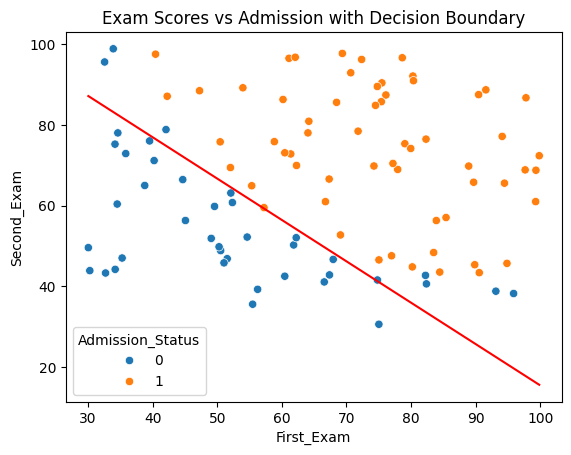

In [364]:
# # Initialize theta
theta = np.zeros(X.shape[1])

# Train the logistic regression model using stochastic gradient descent (SGD)
theta_sgd = train_using_sgd(theta, X, y)

# Scatter plot
sns.scatterplot(data=students, x='First_Exam', y='Second_Exam', hue='Admission_Status')

# Decision boundary
plot_x = np.linspace(students['First_Exam'].min(), students['First_Exam'].max(), 100)
plot_y = -(theta_optimized[0] + theta_optimized[1]*plot_x) / theta_optimized[2]

plt.plot(plot_x, plot_y, color='red')
plt.title('Exam Scores vs Admission with Decision Boundary')
plt.show()

#### 1.2.4 Evaluating logistic regression

After learning the parameters, you can use the model to predict whether a particular student will be admitted. For a student with an Exam 1 score of 53 and an Exam 2 score of 94, print the admission
probability.

In [365]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5
    (i.e., if sigmoid(theta.T*x) >= 0.5, predict 1)

    Parameters
    ----------
    theta : array_like
        Parameters for logistic regression. A vecotor of shape (n+1, ).

    X : array_like
        The data to use for computing predictions. The rows is the number
        of points to compute predictions, and columns is the number of
        features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X.
    """
    


    m = X.shape[0] # Number of training examples

    # You need to return the following variables correctly
    p = np.zeros(m)
    
    # calculate theta transpose X again
    x_dot_theta = X.dot(theta)
    
    # hypothesis using a sigmoid function
    # returns set of probabilities for each element of X
    sig = sigmoid(x_dot_theta)
    
    # clasify each element of X
    # 1 if prob >= 0.5, 0 if otherwise
    p = [1 if s >= 0.5 else 0 for s in np.nditer(sig)]
        
    return p




In [366]:
def accuracy(y_pred, y):
    """
    check prediction accuracy with comparison between predict and actual value
    if two parameter(predicted and actual value) are equal diff will be 0 and
    otherwise will be 1. count of nonzero devided by len of diff is errors. 1 minus
    error is our prediction accuracy

    Parameters
    ----------
    y_pred : array_like
        Predicted values that output of predict function.

    y : array_like
        Actual value of data, (Labels)

    Returns
    -------
    number : float
        model accuracy percentage
    """


    y_pred_prob = predict(X, theta_sgd)
    f'Train accuracy: {np.mean(y_pred_prob == np.array(students["Admission_Status"])) * 100}'
    return accuracy

After you have completed the code in `predict`, we proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct.

In [367]:
# # Predict probability for a student with score 45 on exam 1
# # and score 85 on exam 2
prob = sigmoid(np.dot([1, 45, 85], theta_sgd))
print('For a student with scores 45 and 85,'
      'we predict an admission probability of {:.3f}'.format(prob))

# Compute accuracy on our training set
p = predict(theta_sgd, X)
print('Train Accuracy: {:.2f} %'.format(np.mean(p == y) * 100))


For a student with scores 45 and 85,we predict an admission probability of 0.857
Train Accuracy: 92.00 %


In [368]:
#  Predict probability for a student with score 53 on exam 1 
#  and score 94 on exam 2 
prob = sigmoid(np.dot([1, 53, 94], theta_sgd))
print('For a student with scores 53 and 94,'
      'we predict an admission probability of {:.3f}'.format(prob))

# Compute accuracy on our training set
p = predict(theta_sgd, X)
print('Train Accuracy: {:.2f} %'.format(np.mean(p == y) * 100))


For a student with scores 53 and 94,we predict an admission probability of 0.984
Train Accuracy: 92.00 %


plot the AUC and the ROC curve on your model

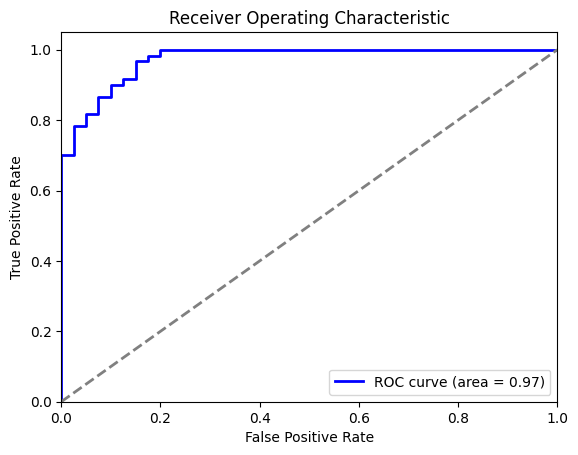

In [369]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(X, y, theta):
    """
    Plot the ROC curve and calculate the AUC.

    Parameters
    ----------
    X : array_like
        Data points. Each row is a single example.
        
    y : array_like
        Labels for the data points. A vector of shape (m, ).

    theta : array_like
        Parameters for logistic regression. Shape (n+1, ).
    """
    # Compute the probability predictions
    probs = sigmoid(np.dot(X, theta))
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y, probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(X, y, theta_sgd)



```
# This is formatted as code
```

## Section 2 Regularized logistic regression

In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.
Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

First, we load the data from a CSV file:

In [370]:
microchips = pd.read_csv('ex2data2.txt', sep=',', header=None)
microchips.columns = ["First_Test", "Second_Test", "Status"]
# type casting from pandas series and pandas dataframe to numpy array
X = np.array(microchips[["First_Test", "Second_Test"]])
y = np.array(microchips["Status"])
# size of dataset
number_of_samples = y.size
# size of X matrix, m= rows, n= features
m,n = X.shape
print('size of samples: {}'.format(number_of_samples))


size of samples: 118


### 2.1 Visualize the data

Similar to the previous parts of this exercise, where the axes are the two test scores, and the positive (y = 1, accepted) and negative (y = 0, rejected) examples are shown with
different markers.

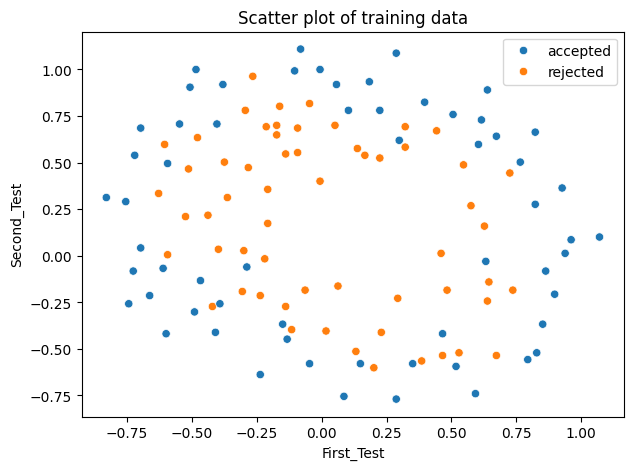

In [371]:
plt.figure(figsize=(7,5))
ax = sns.scatterplot(x='First_Test', y='Second_Test', hue='Status', data=microchips)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:], ['accepted', 'rejected'])
plt.title('Scatter plot of training data')
plt.show(ax)


The above figure shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight-forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

### 2.2 Feature mapping

One way to fit the data better is to create more features from each data point. In the function `map_feature`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$ \text{map_feature}(x) = \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2 & x_1^3 & \dots & x_1 x_2^5 & x_2^6 \end{bmatrix}^T $

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.
While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting. In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.


In [372]:
### make the map feature function

In [373]:
def map_feature(X1, X2, degree=6):
    """
    Maps the two input features to quadratic features used in the regularization exercise.

    Returns a new feature array with more features, comprising of
    X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..

    Parameters
    ----------
    X1 : array_like
        A vector of shape (m, 1), containing one feature for all examples.

    X2 : array_like
        A vector of shape (m, 1), containing a second feature for all examples.
        Inputs X1, X2 must be the same size.

    degree: int, optional
        The polynomial degree.

    Returns
    -------
    : out
        A matrix of of m rows, and columns depend on the degree of polynomial.
    """
    X1 = np.array(X1).reshape(-1,1)
    X2 = np.array(X2).reshape(-1,1)
    
    out = np.ones((X1.shape[0], 1))
    for i in range(1, degree+1):
        for j in range(0, i+1):
            p = (X1**(i-j)) * (X2**j)
            out = np.append(out, p, axis=1)
    return out


In [374]:
X = map_feature(X[:,0], X[:,1])

### 2.3 Cost function and gradient
Note that the parameter $\theta_0$ represents the bias term in the model's weights.
Now you will implement code to compute the cost function and gradient for regularized logistic regression. Complete the code for the function `cost_function_gradient_descent_regularized` below to return the cost and gradient.

Recall that the regularized cost function in logistic regression is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note that you should not regularize the parameters $\theta_0$. The gradient of the cost function is a vector where the $j^{th}$ element is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$

In [375]:
def cost_function_gradient_descent_regularized(theta, X, y, lambda_):
    """
    Compute cost and gradient for logistic regression with regularization.

    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is
        the number of features including any intercept. If we have mapped
        our initial features into polynomial features, then n is the total
        number of polynomial features.

    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).

    y : array_like
        The data labels. A vector with shape (m, ).

    lambda_ : float
        The regularization parameter.

    Returns
    -------
    J : float
        The computed value for the regularized cost function.

    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    """
    m = y.shape[0]
    epsilon = 1e-10
    sum = 0
    for i in range(m):
        h = sigmoid(X[i, :] @ theta)
        sum += -y[i] * np.log(h + epsilon) - (1-y[i]) * np.log(1-h + epsilon)

    J = (1/m) * sum + (lambda_/(2*m)) * np.sum(theta[1:]**2)


    grad = np.zeros(theta.shape)
    for j in range(len(theta)):
        sum = 0
        if j == 0:
            for i in range(m):
                h = sigmoid(X[i, :] @ theta)
                sum += (h - y[i]) * X[i, j]
            grad[j] = (1/m) * sum
        else:
            for i in range(m):
                h = sigmoid(X[i, :] @ theta)
                sum += (h - y[i]) * X[i, j]
            grad[j] = (1/m) * sum + (lambda_/m) * theta[j]

    return J, grad

#### 2.3.1 Learning parameters using momentum

Similar to the previous parts, you will optimize the Regularized logistic regression using the momentum algorithm optimize the model with $\lambda = 1$, $\lambda = 0$

In [376]:
def train_using_momentum(theta, X, y,lmbda, learning_rate= 0.0001, beta =0.01  , epochs= 10000):
    """
    Perform gradient descent with momentum to train the Regularized logistic regression model.
    """

    for epoch in range(epochs):
        for i in range(len(X)):
            gradients = np.zeros(theta.shape)
            xi = X[i]
            yi = y[i]
            sig = sigmoid(xi @ theta)

            if 0 == 1:
                prev_gradients = np.zeros(theta.shape)
            else:
                prev_gradients = gradients
            
            # Compute the gradients of the random example
            for j in range(len(theta)):
                if j == 0:
                    gradients[j] = (sig - yi) * xi[j]
                else:
                    gradients[j] = (sig - yi) * xi[j] + (lmbda/m) * theta[j]

            # Update the parameters
            theta = theta - (beta * prev_gradients - learning_rate * gradients)

    return theta

In [377]:

initial_theta = np.zeros(X.shape[1])
theta_optimized = train_using_momentum(initial_theta, X, y, lmbda=1)
model_predicted = predict(theta_optimized, X)

print("Train Accuracy: {:.1f}".format((np.mean(model_predicted == y) * 100)))
print("Expected accuracy (with lambda = 1): 83.1 % (approx)\n")

Train Accuracy: 81.4
Expected accuracy (with lambda = 1): 83.1 % (approx)



### plot the decision boundery for $\lambda =1$




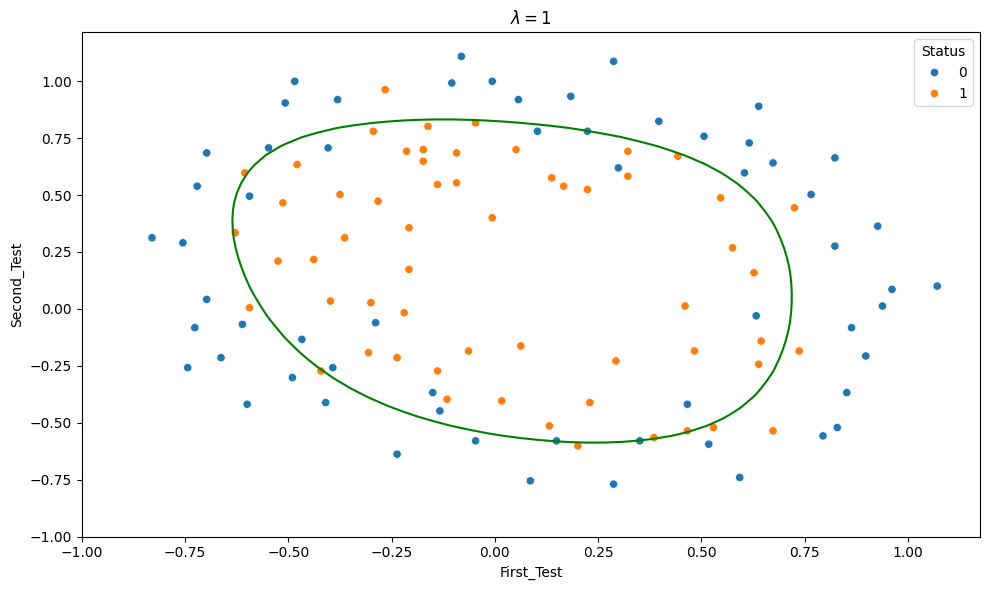

In [378]:
lambda_reg = 1
fig, axs = plt.subplots(figsize=(10,6))
u = np.linspace(-1, 1, 50)
v = np.linspace(-1, 1, 50)

theta_opt = train_using_momentum(initial_theta, X, y,  lmbda=1)
z = np.zeros((u.shape[0], v.shape[0]))
for i in range(len(u)):
    for j in range(len(v)):
        z[i,j] = map_feature(u[i], v[j]).dot(theta_opt).item()
    
sns.scatterplot(x='First_Test', y='Second_Test', hue='Status', data=microchips)
    
axs.contour(u, v, z.T, levels=[0], colors='green')
axs.set_title('$\lambda={}$'.format(lambda_reg))
fig.tight_layout()
plt.show()

### plot the decision boundery for $\lambda=0$




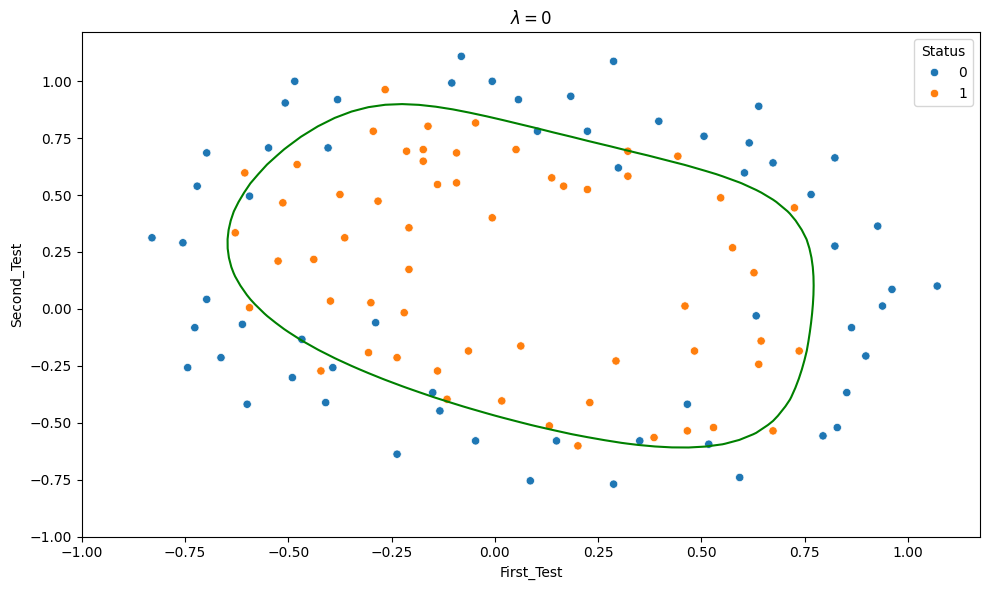

In [379]:
lambda_reg = 0
fig, axs = plt.subplots(figsize=(10,6))
u = np.linspace(-1, 1, 50)
v = np.linspace(-1, 1, 50)

theta_opt = train_using_momentum(initial_theta, X, y,  lmbda=0)
z = np.zeros((u.shape[0], v.shape[0]))
for i in range(len(u)):
    for j in range(len(v)):
        z[i,j] = map_feature(u[i], v[j]).dot(theta_opt).item()
    
sns.scatterplot(x='First_Test', y='Second_Test', hue='Status', data=microchips)
    
axs.contour(u, v, z.T, levels=[0], colors='green')
axs.set_title('$\lambda={}$'.format(lambda_reg))
fig.tight_layout()
plt.show()

